<a id='top'></a>
## Can Amazon Reviews Help Businesses Learn their Best Customers? 

#### Contributors: Muoyo Okome, Jill Carrie



[Back to Top ↑](#top)

<a id='toc'></a>
### Table of Contents
1. [Problem Statement](#problemstatement)
2. [Data Sources](#datasources)
3. [Data Cleaning](#datacleaning)
4. [Classification Analysis](#classification)  
    - [Logistic Regression](#logisticregression)
    - [K Nearest Neighbors](#kneighbors)
    - [Decision Trees](#decisiontrees)
    - [Bagged Trees](#baggedtrees)
    - [Random Forest](#randomforest)
    - [Adaboost](#adaboost)
    - [Gradient Boost](#gradientboost)
5. [Findings](#findings)
6. [Vizualizations](#findings)
7. [Next Steps](#nextsteps)

In [27]:
# Import necessary libraries
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, STOPWORDS
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

<a id='problemstatement'></a>
### Problem Statement

**Can Amazon Reviews Help Businesses Learn their Best Customers?**

The key question we look to answer is whether knowing the text of an Amazon Customer Review can help us predict the star rating of that review.

Eventually our goal is to provide these insights to businesses as a service to help them identify customers most likely to love or hate their products based on the things they are saying.

[Back to Top ↑](#top)

<a id='datasources'></a>
### Data Sources

#### **[AWS Open Data: Amazon Customer Reviews Dataset](https://registry.opendata.aws/amazon:reviews/)**

- Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset.

- A collection of reviews written in the Amazon.com marketplace and associated metadata from 1995 until 2015. This is intended to facilitate study into the properties (and the evolution) of customer reviews potentially including how people evaluate and express their experiences with respect to products at scale. (130M+ customer reviews) 

<br> 

[Back to Top ↑](#top)

In [115]:
# Import python files we've created to help
%run ../python_files/nlp
%run ../python_files/data_cleaning
%run ../python_files/classification
%run ../python_files/visualizations

In [66]:
# Read in original data
df = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz', sep='\t', error_bad_lines=False, warn_bad_lines=False)

<a id='datacleaning'></a>
### Data Cleaning

In preparation for our analysis, in addition to dealing with missing values and limiting our scope to the columns of interest, we also used [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) to give us positive, negative, neutral, and compound sentiment scores for each review in our dataset. Finally, we leveraged SMOTE to deal with the issue of unbalanced classes in our data.

To make the project more modular and easier to follow & build upon, we created separate .py files to handle the heavy lifting for tasks such as data extraction & cleaning, visualizations, and natural language processing.

We chose to focus on the Watches category (~960,000 customer reviews) for this analysis, though with sufficient time, the process can be generalized to the entire dataset.

In [67]:
# Clean data & load into final dataframe

In [68]:
df = clean_data(df, 25000)
df = append_sentiment_scores(df)



[Back to Top ↑](#top)

<a id='classification'></a>
### Classification Analysis

With the help of the scikit-learn package, our next step was to run a series of classification models, each time with the goal of using insight gained from the review text, to predict the number of stars in the review's star rating.

- **Dependent variable:** **star_rating:** The 1-5 star rating of the review. <p>

- **Independendent variables:**
    - **helpful_votes:** Number of helpful votes the review received.
    - **total_votes:** Total number of votes the review received.
    - **neg:** Review's 'negative' rating via VADER Sentiment Analysis.
    - **neu:** Review's 'neutral' rating via VADER Sentiment Analysis.
    - **pos:** Review's 'positive' rating via VADER Sentiment Analysis.
    - **compound:** Review's 'compound' rating via VADER Sentiment Analysis.

To guard against data leakage, we split our dataset into training data and test data.

In [22]:
X_train, X_test, y_train, y_test = get_train_test_split(df, test_size=.25)



[Back to Top ↑](#top)

<a id='logisticregression'></a>
### Logistic Regression

              precision    recall  f1-score   support

           1       0.45      0.59      0.51     11106
           2       0.33      0.27      0.30     11106
           3       0.31      0.13      0.18     11106
           4       0.32      0.40      0.35     11106
           5       0.51      0.61      0.56     11106

    accuracy                           0.40     55530
   macro avg       0.38      0.40      0.38     55530
weighted avg       0.38      0.40      0.38     55530



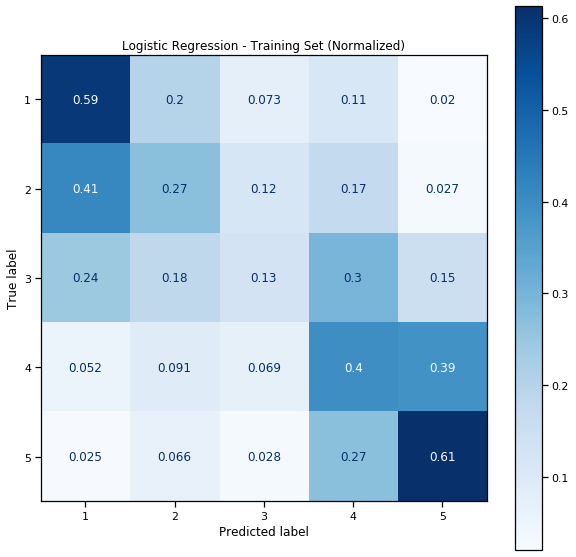

In [118]:
clf_lr = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear', penalty='l2')
clf_lr.fit(X_train, y_train)

y_hat_lr_train = clf_lr.predict(X_train)
print(classification_report(y_train, y_hat_lr_train))
show_confusion_matrix(clf_lr, X_train, y_train, title='Logistic Regression - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.46      0.60      0.52       568
           2       0.12      0.21      0.15       354
           3       0.16      0.09      0.12       508
           4       0.27      0.39      0.32      1159
           5       0.80      0.63      0.71      3661

    accuracy                           0.52      6250
   macro avg       0.36      0.39      0.36      6250
weighted avg       0.58      0.52      0.54      6250



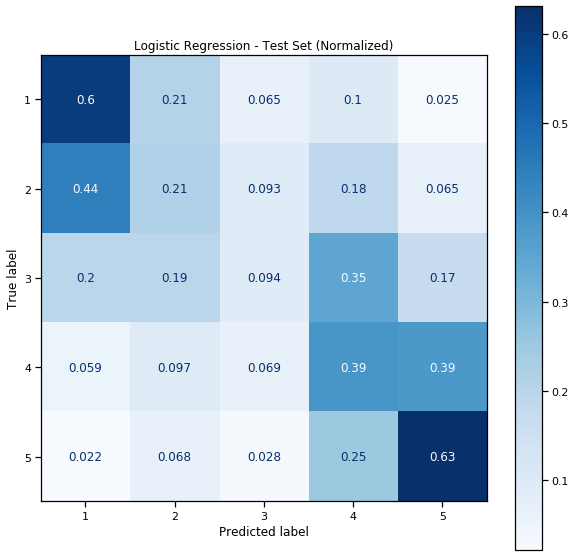

In [116]:
y_hat_lr_test = clf_lr.predict(X_test)
print(classification_report(y_test, y_hat_lr_test))
show_confusion_matrix(clf_lr, X_test, y_test, title='Logistic Regression - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='kneighbors'></a>
### K Nearest Neighbors

              precision    recall  f1-score   support

           1       0.79      0.84      0.82     11106
           2       0.72      0.86      0.79     11106
           3       0.77      0.79      0.78     11106
           4       0.75      0.74      0.75     11106
           5       0.82      0.59      0.69     11106

    accuracy                           0.77     55530
   macro avg       0.77      0.77      0.76     55530
weighted avg       0.77      0.77      0.76     55530



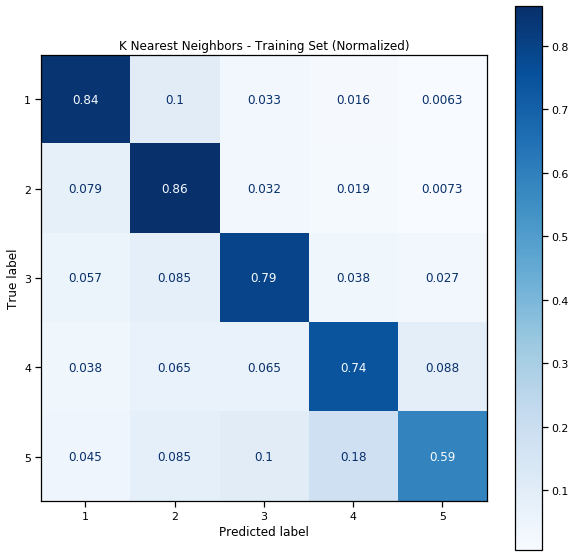

In [124]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

y_hat_knn_train = clf_knn.predict(X_train)
print(classification_report(y_train, y_hat_knn_train))
show_confusion_matrix(clf_knn, X_train, y_train, title='K Nearest Neighbors - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.33      0.41      0.36       568
           2       0.11      0.26      0.15       354
           3       0.13      0.25      0.17       508
           4       0.23      0.28      0.25      1159
           5       0.79      0.50      0.61      3661

    accuracy                           0.42      6250
   macro avg       0.32      0.34      0.31      6250
weighted avg       0.55      0.42      0.46      6250



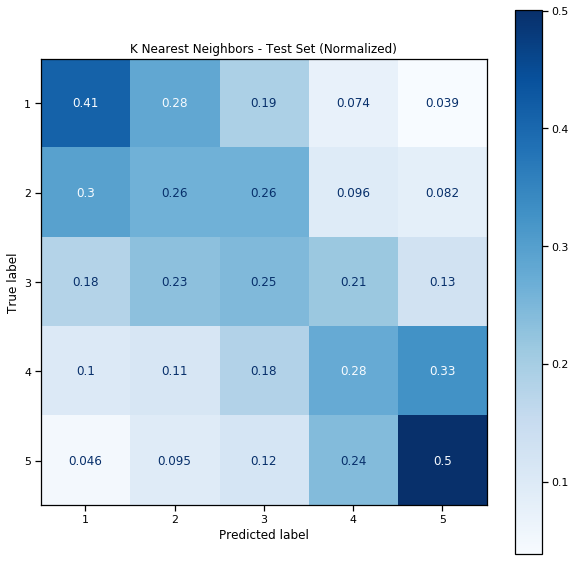

In [117]:
y_hat_knn_test = clf_knn.predict(X_test)
print(classification_report(y_test, y_hat_knn_test))
show_confusion_matrix(clf_knn, X_test, y_test, title='K Nearest Neighbors - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='#decisiontrees'></a>
### Decision Trees

              precision    recall  f1-score   support

           1       0.98      0.94      0.96     11106
           2       0.85      0.99      0.92     11106
           3       0.99      0.95      0.97     11106
           4       0.98      0.95      0.96     11106
           5       0.97      0.94      0.96     11106

    accuracy                           0.95     55530
   macro avg       0.96      0.95      0.95     55530
weighted avg       0.96      0.95      0.95     55530



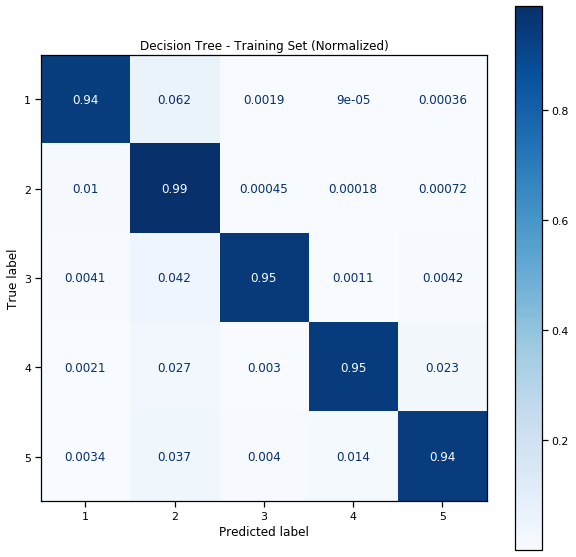

In [126]:
clf_dt = DecisionTreeClassifier(criterion='entropy')
clf_dt.fit(X_train, y_train)

y_hat_dt_train = clf_dt.predict(X_train)
print(classification_report(y_train, y_hat_dt_train))
show_confusion_matrix(clf_dt, X_train, y_train, title='Decision Tree - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.35      0.37      0.36       568
           2       0.11      0.24      0.15       354
           3       0.13      0.19      0.15       508
           4       0.22      0.25      0.24      1159
           5       0.74      0.58      0.65      3661

    accuracy                           0.45      6250
   macro avg       0.31      0.32      0.31      6250
weighted avg       0.53      0.45      0.48      6250



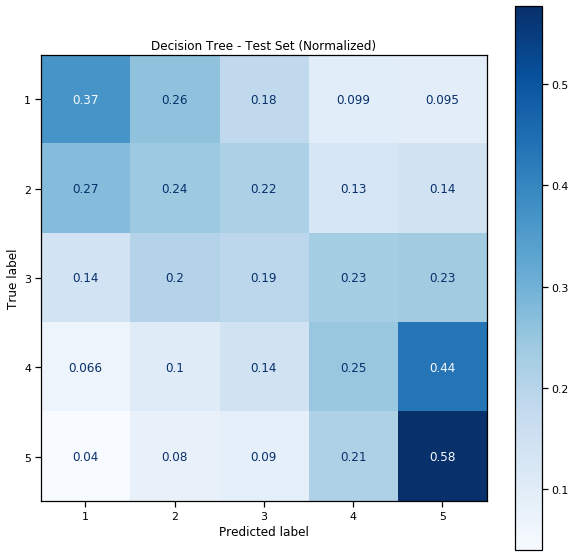

In [119]:
y_hat_dt_test = clf_dt.predict(X_test)
print(classification_report(y_test, y_hat_dt_test))
show_confusion_matrix(clf_dt, X_test, y_test, title='Decision Tree - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='#baggedtrees'></a>
### Bagged Trees

              precision    recall  f1-score   support

           1       0.57      0.57      0.57     11106
           2       0.44      0.52      0.48     11106
           3       0.39      0.36      0.38     11106
           4       0.41      0.32      0.36     11106
           5       0.55      0.63      0.59     11106

    accuracy                           0.48     55530
   macro avg       0.48      0.48      0.48     55530
weighted avg       0.48      0.48      0.48     55530



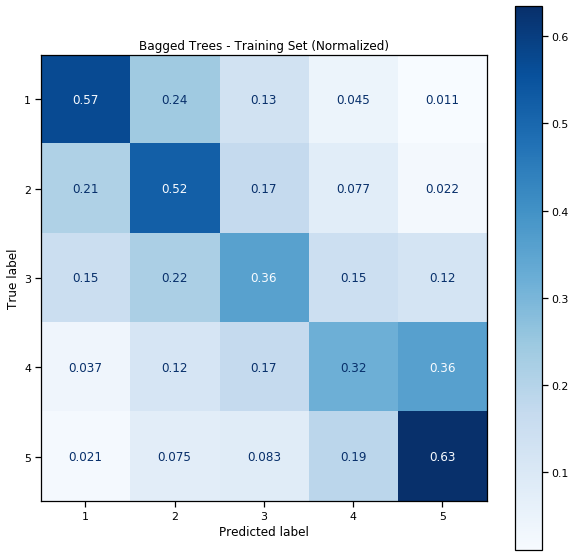

In [127]:
clf_bagged = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_leaf_nodes=100), 
                                 n_estimators=20)
clf_bagged.fit(X_train, y_train)

y_hat_bagged_train = clf_bagged.predict(X_train)
print(classification_report(y_train, y_hat_bagged_train))
show_confusion_matrix(clf_bagged, X_train, y_train, title='Bagged Trees - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.47      0.47      0.47       568
           2       0.13      0.31      0.18       354
           3       0.15      0.22      0.18       508
           4       0.27      0.25      0.26      1159
           5       0.79      0.65      0.71      3661

    accuracy                           0.50      6250
   macro avg       0.36      0.38      0.36      6250
weighted avg       0.57      0.50      0.53      6250



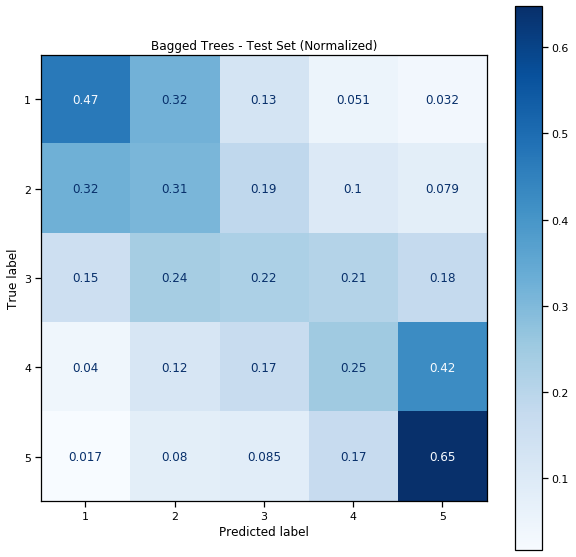

In [120]:
y_hat_bagged_test = clf_bagged.predict(X_test)
print(classification_report(y_test, y_hat_bagged_test))
show_confusion_matrix(clf_bagged, X_test, y_test, title='Bagged Trees - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='randomforest'></a>
### Random Forest

              precision    recall  f1-score   support

           1       0.66      0.65      0.65     11106
           2       0.54      0.67      0.60     11106
           3       0.58      0.50      0.53     11106
           4       0.56      0.48      0.52     11106
           5       0.63      0.66      0.64     11106

    accuracy                           0.59     55530
   macro avg       0.59      0.59      0.59     55530
weighted avg       0.59      0.59      0.59     55530



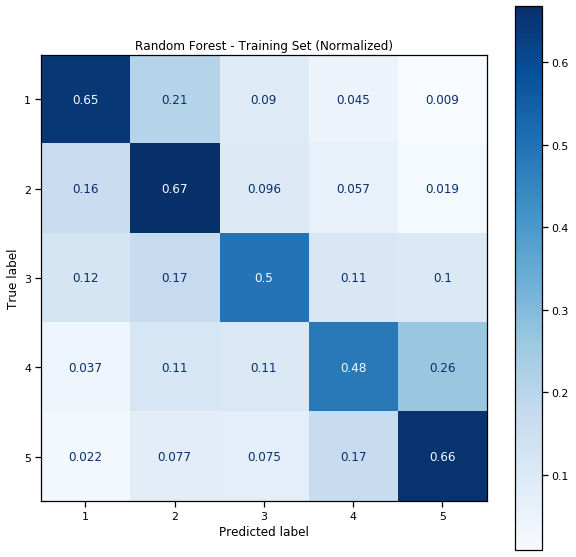

In [128]:
clf_forest = RandomForestClassifier(n_estimators=100, max_depth = 10)
clf_forest.fit(X_train, y_train)

y_hat_forest_train = clf_forest.predict(X_train)
print(classification_report(y_train, y_hat_forest_train))
show_confusion_matrix(clf_forest, X_train, y_train, title='Random Forest - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.43      0.49      0.46       568
           2       0.13      0.30      0.18       354
           3       0.15      0.19      0.17       508
           4       0.26      0.28      0.27      1159
           5       0.80      0.63      0.70      3661

    accuracy                           0.50      6250
   macro avg       0.35      0.38      0.36      6250
weighted avg       0.57      0.50      0.53      6250



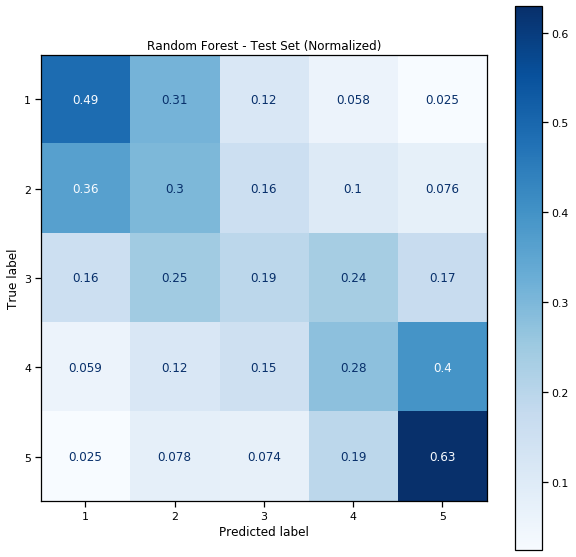

In [121]:
y_hat_forest_test = clf_forest.predict(X_test)
print(classification_report(y_test, y_hat_forest_test))
show_confusion_matrix(clf_forest, X_test, y_test, title='Random Forest - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='adaboost'></a>
### Adaboost

              precision    recall  f1-score   support

           1       0.49      0.49      0.49     11106
           2       0.33      0.42      0.37     11106
           3       0.32      0.21      0.25     11106
           4       0.34      0.31      0.32     11106
           5       0.53      0.63      0.57     11106

    accuracy                           0.41     55530
   macro avg       0.40      0.41      0.40     55530
weighted avg       0.40      0.41      0.40     55530



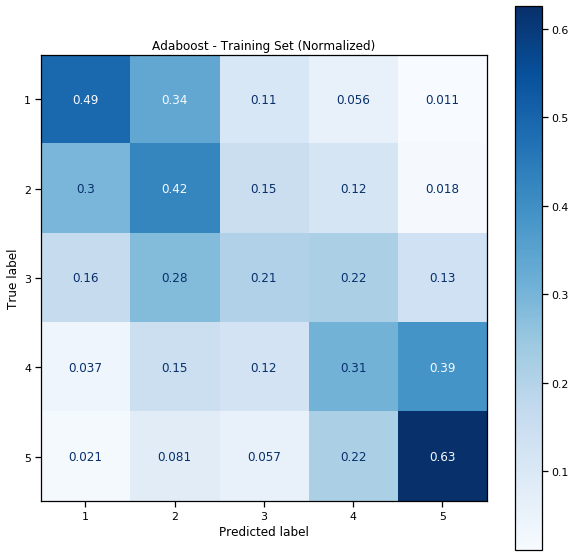

In [129]:
clf_ab = AdaBoostClassifier()
clf_ab.fit(X_train, y_train)

y_hat_ab_train = clf_ab.predict(X_train)
print(classification_report(y_train, y_hat_ab_train))
show_confusion_matrix(clf_ab, X_train, y_train, title='Adaboost - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.45      0.47      0.46       568
           2       0.15      0.38      0.21       354
           3       0.14      0.14      0.14       508
           4       0.27      0.29      0.28      1159
           5       0.79      0.65      0.72      3661

    accuracy                           0.51      6250
   macro avg       0.36      0.39      0.36      6250
weighted avg       0.58      0.51      0.54      6250



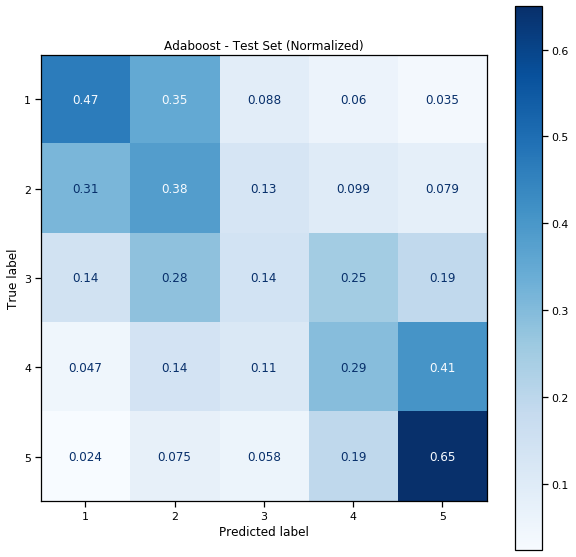

In [122]:
y_hat_ab_test = clf_ab.predict(X_test)
print(classification_report(y_test, y_hat_ab_test))
show_confusion_matrix(clf_ab, X_test, y_test, title='Adaboost - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='gradientboost'></a>
### Gradient Boost

In [51]:
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)

y_hat_gb_train = clf_gb.predict(X_train)

print(classification_report(y_train, y_hat_gb_train))
show_confusion_matrix(clf_gb, X_train, y_train, title='Gradient Boost - Training Set (Normalized)')

[[5992 3111 1361  523  119]
 [2372 5867 1620 1042  205]
 [1640 2748 3556 1885 1277]
 [ 344 1518 1662 4080 3502]
 [ 222  871  854 2253 6906]] 


              precision    recall  f1-score   support

           1       0.57      0.54      0.55     11106
           2       0.42      0.53      0.47     11106
           3       0.39      0.32      0.35     11106
           4       0.42      0.37      0.39     11106
           5       0.58      0.62      0.60     11106

    accuracy                           0.48     55530
   macro avg       0.47      0.48      0.47     55530
weighted avg       0.47      0.48      0.47     55530



              precision    recall  f1-score   support

           1       0.48      0.48      0.48       568
           2       0.13      0.34      0.19       354
           3       0.15      0.19      0.16       508
           4       0.25      0.27      0.26      1159
           5       0.79      0.62      0.70      3661

    accuracy                           0.49      6250
   macro avg       0.36      0.38      0.36      6250
weighted avg       0.57      0.49      0.52      6250



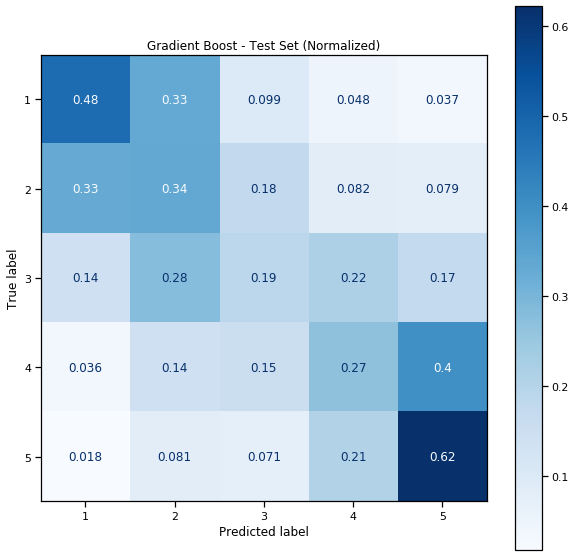

In [123]:
y_hat_gb_test = clf_gb.predict(X_test)
print(classification_report(y_test, y_hat_gb_test))
show_confusion_matrix(clf_gb, X_test, y_test, title='Gradient Boost - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='findings'></a>
### Findings

1. **Drivers can earn the most at 5 am.** Peak fares occur between 4-6am on a daily basis. Across all the 7 days of the week, the peak earning time for drivers is always between 4-6 am. Factors that can help explain this trend is the fact that to earn more drivers are looking at driving long distances in less amount of time, early mornings provide an opportunity for long distances mostly to airports and relatively less traffic hence distance can be covered in shorter periods of time.<p>

2. **Airport pickups lead to higher earnings.** The 2 airports in Chicago are by far the highest earning pickup community areas, Neighborhoods that are far from the airport and with limited public transport lead the rest of the other community areas.<p>

3. **Day of week alone does not significantly affect expected fare.** Average fares tend to fall in the same range when viewed at the daily level. We need to combine with other predictors to get a better sense of the true relationships.<p>

4. **Strong relationship between temperature and trip fare. Of the independent variables used, Temperature has the strongest correlation with Fares. The colder it gets the more average fares increase**<p>



[Back to Top ↑](#top)

<a id='visualizations'></a>
### Visualizations

Let's further illustrate our findings via the illustrations below.

### Word Cloud for 5-Star Reviews

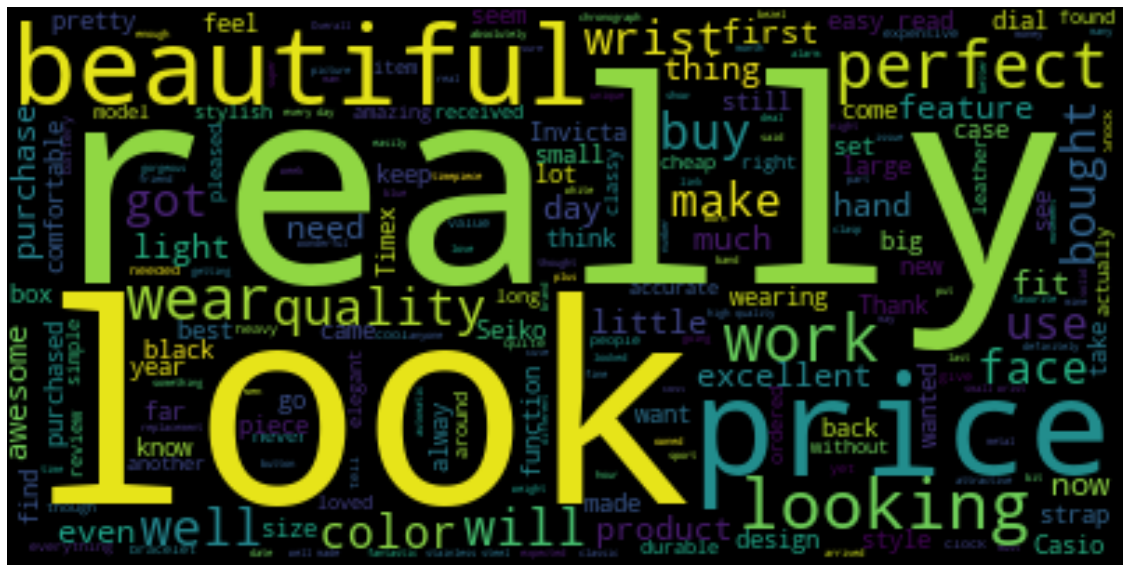

In [92]:
n_star_review_wordcloud(df, 5)

### Word Cloud for 3-Star Reviews


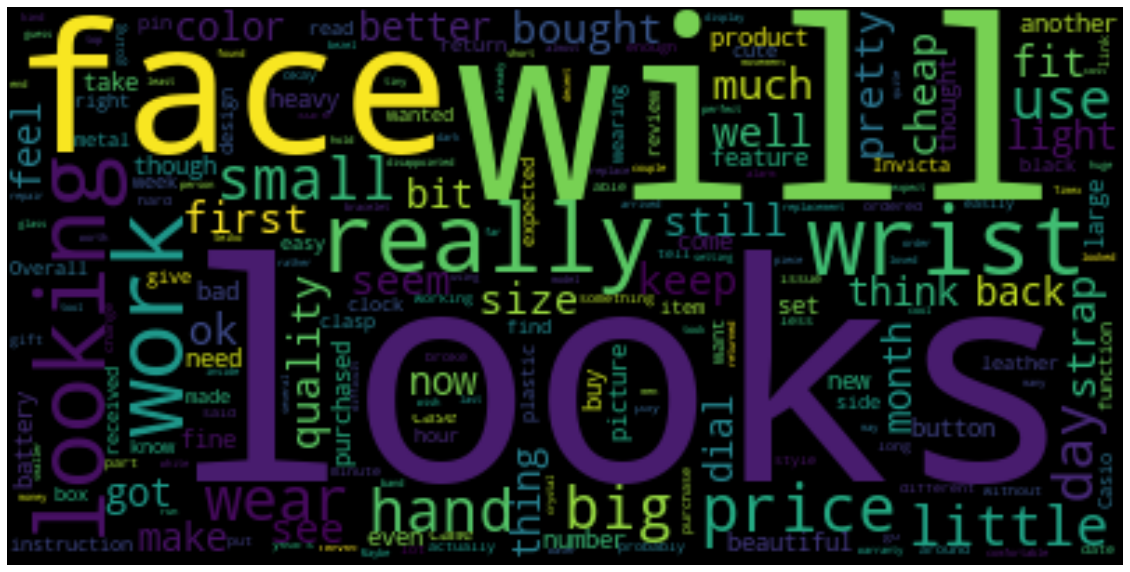

In [93]:
n_star_review_wordcloud(df, 3)

### Word Cloud for 1-Star Reviews


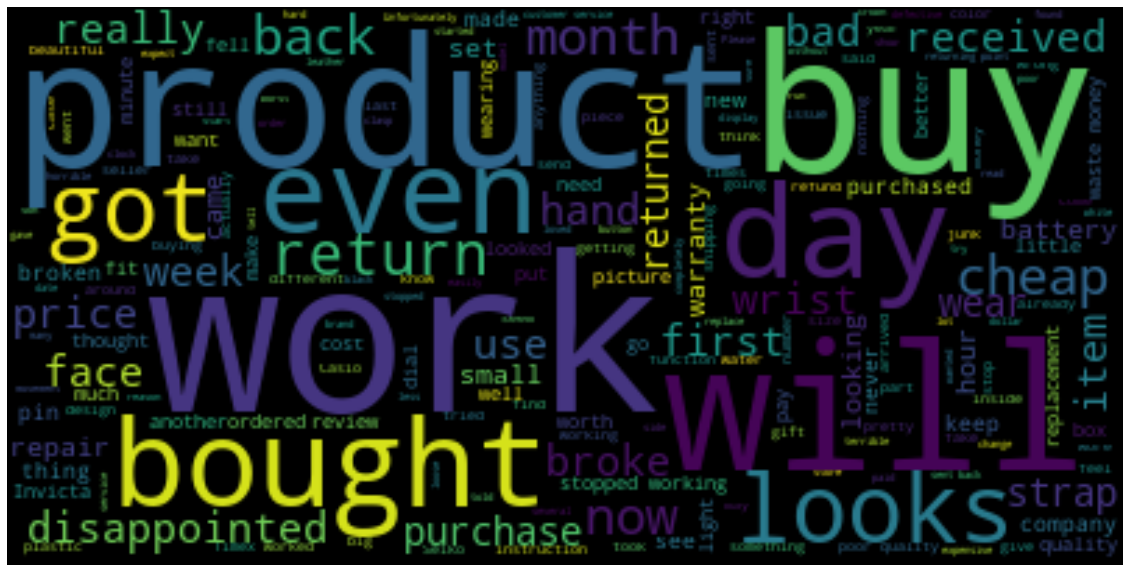

In [94]:
n_star_review_wordcloud(df, 1)


[Back to Top ↑](#top)

<a id='nextsteps'></a>
### Next Steps

1. **Further refine the model to provide recommendations of ideal pickup location given time & weather.** To be able to provide drivers realtime predictions of where and when to be in order to earn the most, using their location, weather conditions, time and day of the week.<p>

2. **Finding additional and more correct independent variables to increase models predictive power** that may include events and activities going on in Chicago, emergencies, data on airport arrivals and delays, etc.<p>

3. **Extend our model to help different groups such as riders & competing rideshare companies.** Can we design models that can help riders to determine when a fee will drop and by how much to help them make better decisions of when to take a ride that will save them the most money?<p>



[Back to Top ↑](#top)